# ResNET-18

### 1. Import bibliotek

In [28]:
import os

import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import seaborn as sns

from datasets import load_from_disk
from create_data import download_and_save_dataset
from heplers.early_stopping import EarlyStopping
from heplers.augmentation import AugmentedAudioDataset
from heplers.resnet_model_definition import AudioResNet
from config import (BATCH_SIZE, NUM_EPOCHS, LEARNING_RATE, WEIGHT_DECAY,
                    DROPOUT_RATE, EARLY_STOPPING_PATIENCE, MODEL_DIR,
                    TIMESTAMP, MODEL_PATH, MAX_LENGTH, SEED, DATASET_PATH)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report


### 2. Pobieranie Datasetu

In [17]:
# Sprawdź czy folder data istnieje i załaduj dataset
dataset_path = DATASET_PATH
if os.path.exists(dataset_path):
    try:
        print("Ładowanie datasetu z dysku...")
        dataset = load_from_disk(dataset_path)
    except Exception as e:
        print(f"Błąd podczas ładowania datasetu: {e}")
        print("Pobieranie datasetu ponownie...")
        dataset = download_and_save_dataset()
else:
    print("Folder 'data' nie istnieje. Pobieranie datasetu...")
    dataset = download_and_save_dataset()

Ładowanie datasetu z dysku...


### 3. Podstawowe informacje o datasecie.

Struktura datasetu:
DatasetDict({
    train: Dataset({
        features: ['file_id', 'audio', 'emotion', 'raw_text', 'normalized_text', 'speaker_id', 'gender', 'age'],
        num_rows: 4481
    })
})

Kolumny w datasecie:
{'file_id': Value(dtype='string', id=None), 'audio': Audio(sampling_rate=None, mono=True, decode=True, id=None), 'emotion': Value(dtype='string', id=None), 'raw_text': Value(dtype='string', id=None), 'normalized_text': Value(dtype='string', id=None), 'speaker_id': Value(dtype='string', id=None), 'gender': Value(dtype='string', id=None), 'age': Value(dtype='int32', id=None)}

Liczba próbek w zbiorze: 4481

Rozkład emocji:
neutral      809
sadness      769
happiness    749
anger        749
fear         736
surprised    669
Name: count, dtype: int64


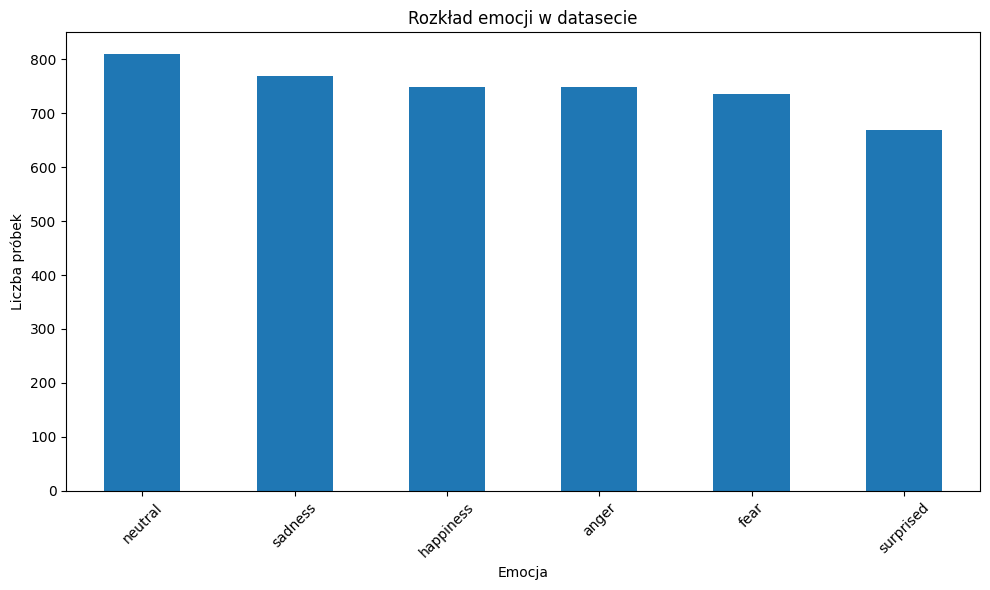

In [ ]:
# Podstawowe informacje o strukturze datasetu
print("Struktura datasetu:")
print(dataset)

#  Kolumny (features) w datasecie
print("\nKolumny w datasecie:")
print(dataset['train'].features)


# Podstawowe statystyki
# Liczba próbek
print(f"\nLiczba próbek w zbiorze: {len(dataset['train'])}")

# Rozkład emocji
emotions = dataset['train']['emotion']
emotion_counts = pd.Series(emotions).value_counts()

print("\nRozkład emocji:")
print(emotion_counts)

# Wizualizacja rozkładu emocji
plt.figure(figsize=(10, 6))
emotion_counts.plot(kind='bar')
plt.title('Rozkład emocji w datasecie')
plt.xlabel('Emocja')
plt.ylabel('Liczba próbek')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 4. Przetwarzanie próbek audio

In [19]:
# Ustawienie seed dla powtarzalności wyników
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Przetwarzanie danych audio
print("Przetwarzanie próbek audio...")
features = []
labels = []

for sample in tqdm(dataset['train'], desc="Przetwarzanie próbek audio"):
    audio_array = sample['audio']['array']
    sr = sample['audio']['sampling_rate']
    
    # Ujednolicenie długości
    target_length = int(MAX_LENGTH * sr)
    if len(audio_array) > target_length:
        audio_array = audio_array[:target_length]
    else:
        padding = np.zeros(target_length - len(audio_array))
        audio_array = np.concatenate([audio_array, padding])
    
    # Ekstrakcja melspektrogramu
    S = librosa.feature.melspectrogram(y=audio_array, sr=sr, n_mels=128)
    S_db = librosa.power_to_db(S, ref=np.max)
    features.append(S_db)
    
    # Dodanie etykiety
    labels.append(sample['emotion'])


Przetwarzanie próbek audio...


Przetwarzanie próbek audio: 100%|██████████| 4481/4481 [00:42<00:00, 105.36it/s]


#### Konwersja i normalizacja danych audio oraz etykiet

In [20]:
# Konwersja list na tablice numpy
features = np.array(features)
features = features.reshape(features.shape[0], 1, features.shape[1], features.shape[2])

# Normalizacja danych (standardyzacja)
mean = np.mean(features)
std = np.std(features)
features = (features - mean) / std

# Konwersja etykiet na liczby
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
num_classes = len(np.unique(labels))
print(f"Liczba klas emocji: {num_classes}")
print(f"Mapowanie klas: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

Liczba klas emocji: 6
Mapowanie klas: {'anger': 0, 'fear': 1, 'happiness': 2, 'neutral': 3, 'sadness': 4, 'surprised': 5}


### 5. Podział danych na zbiory treningowe, walidacyjne i testowe


In [21]:
# Podział na zbiory
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=SEED, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train)

# Utworzenie katalogu dla modeli i wykresów
os.makedirs(MODEL_DIR, exist_ok=True)

### 6. Inicjalizacja modelu i optymalizatora

In [22]:
# Inicjalizacja modelu, funkcji straty i optymalizatora
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Używane urządzenie: {device}")

# Inicjalizacja modelu
model = AudioResNet(num_classes=num_classes, dropout_rate=0.5)
model = model.to(device)

# Inicjalizacja funkcji straty i optymalizatora
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Dodanie regularyzacji L2
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

Używane urządzenie: cpu


 #### Przygotowanie zestawów danych z augmentacją i ładowanie ich do DataLoaderów

In [23]:
# Przygotowanie zestawów danych z augmentacją
train_dataset = AugmentedAudioDataset(X_train, y_train, augment=True)
val_dataset = AugmentedAudioDataset(X_val, y_val, augment=False)
test_dataset = AugmentedAudioDataset(X_test, y_test, augment=False)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Ścieżka do zapisywania modelu
early_stopping = EarlyStopping(patience=EARLY_STOPPING_PATIENCE, path=MODEL_PATH)

# Śledzenie historii treningu
history = {
    'train_loss': [],
    'val_loss': [],
    'val_accuracy': []
}

#### Pętla treningowa i walidacja modelu


In [24]:
#Pętla treningowa
print("Rozpoczynanie treningu...")
for epoch in range(NUM_EPOCHS):
    # Faza treningu
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    history['train_loss'].append(train_loss)
    
    # Faza walidacji
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            # Obliczanie straty walidacyjnej
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            # Obliczanie dokładności
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total
    
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)
    
    print(f'Epoka {epoch + 1}/{NUM_EPOCHS}, Strata treningu: {train_loss:.4f}, '
          f'Strata walidacji: {val_loss:.4f}, Dokładność walidacji: {val_accuracy:.2f}%')
    
    # Aktualizacja schedulera
    scheduler.step(val_loss)
    
    # Sprawdzenie warunku early stopping
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping aktywowane!")
        break


Rozpoczynanie treningu...
Epoka 1/50, Strata treningu: 1.8862, Strata walidacji: 1.6923, Dokładność walidacji: 36.54%
Validation loss decreased. Saving model to model_outputs\best_model_20250406_160046.pt
Epoka 2/50, Strata treningu: 1.3862, Strata walidacji: 1.0706, Dokładność walidacji: 61.37%
Validation loss decreased. Saving model to model_outputs\best_model_20250406_160046.pt
Epoka 3/50, Strata treningu: 1.0496, Strata walidacji: 1.2927, Dokładność walidacji: 55.93%
EarlyStopping counter: 1 out of 7
Epoka 4/50, Strata treningu: 0.9022, Strata walidacji: 1.1166, Dokładność walidacji: 62.76%
EarlyStopping counter: 2 out of 7
Epoka 5/50, Strata treningu: 0.7119, Strata walidacji: 0.9496, Dokładność walidacji: 67.36%
Validation loss decreased. Saving model to model_outputs\best_model_20250406_160046.pt
Epoka 6/50, Strata treningu: 0.6274, Strata walidacji: 1.2532, Dokładność walidacji: 60.81%
EarlyStopping counter: 1 out of 7
Epoka 7/50, Strata treningu: 0.5480, Strata walidacji: 0.59

### 7. Ewaluacja na zbiorze testowym

Wszelkie raporty z ewaluacji modelu dostępne są w folderze model_outputs


In [25]:
# Wczytanie najlepszego modelu
model.load_state_dict(torch.load(MODEL_PATH))

# Testowanie modelu
model.eval()
all_preds = []
all_labels = []
test_correct = 0
test_total = 0
test_loss = 0.0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        # Obliczanie straty testowej
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        # Obliczanie dokładności
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        
        # Zapisanie predykcji i rzeczywistych etykiet
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss = test_loss / len(test_loader)
test_accuracy = 100 * test_correct / test_total
print(f'Dokładność testu: {test_accuracy:.2f}%, Strata testu: {test_loss:.4f}')

Dokładność testu: 91.42%, Strata testu: 0.2718


In [29]:
#Macierz konfuzji
cm = confusion_matrix(all_labels, all_preds)
class_names = label_encoder.classes_

# Wizualizacja macierzy konfuzji
plt.figure(figsize=(10, 8))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Purples', xticklabels=class_names, yticklabels=class_names)
plt.title('Znormalizowana macierz konfuzji')
plt.ylabel('Rzeczywista etykieta')
plt.xlabel('Przewidziana etykieta')
plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, f'confusion_matrix_{TIMESTAMP}.png'))
plt.close()

#### Raport klasyfikacji

In [35]:
report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)
report_df.to_csv(os.path.join(MODEL_DIR, f'classification_report_{TIMESTAMP}.csv'))

              precision    recall  f1-score     support
anger          0.958042  0.913333  0.935154  150.000000
fear           0.951724  0.938776  0.945205  147.000000
happiness      0.859060  0.853333  0.856187  150.000000
neutral        0.917647  0.962963  0.939759  162.000000
sadness        0.937107  0.967532  0.952077  154.000000
surprised      0.854962  0.835821  0.845283  134.000000
accuracy       0.914158  0.914158  0.914158    0.914158
macro avg      0.913090  0.911960  0.912278  897.000000
weighted avg   0.914166  0.914158  0.913908  897.000000


In [31]:
# Wizualizacja historii treningu
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Trening')
plt.plot(history['val_loss'], label='Walidacja')
plt.title('Strata podczas treningu')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['val_accuracy'], label='Walidacja')
plt.title('Dokładność podczas treningu')
plt.xlabel('Epoka')
plt.ylabel('Dokładność (%)')
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(MODEL_DIR, f'training_history_{TIMESTAMP}.png'))
plt.close()

In [32]:
# Zapisanie hiperparametrów i wyników
results = {
    'hyperparameters': {
        'batch_size': BATCH_SIZE,
        'initial_lr': LEARNING_RATE,
        'weight_decay': WEIGHT_DECAY,
        'dropout_rate': DROPOUT_RATE,
        'early_stopping_patience': EARLY_STOPPING_PATIENCE,
        'max_epochs': NUM_EPOCHS,
        'actual_epochs': epoch + 1
    },
    'performance': {
        'test_accuracy': test_accuracy,
        'test_loss': test_loss,
        'val_accuracy': history['val_accuracy'][-1],
        'val_loss': history['val_loss'][-1]
    }
}

# Zapisanie wyników do pliku
with open(os.path.join(MODEL_DIR, f'results_{TIMESTAMP}.txt'), 'w') as f:
    for section, values in results.items():
        f.write(f"{section.upper()}:\n")
        for key, value in values.items():
            f.write(f"  {key}: {value}\n")
        f.write("\n")

In [33]:
# Wczytanie zapisanego modelu
state_dict = torch.load(MODEL_PATH)

# Wyświetlenie struktury modelu
for key in state_dict.keys():
    print(f"Layer: {key}")
    print(f"Shape: {state_dict[key].shape}")
    print("---")

Layer: resnet.conv1.weight
Shape: torch.Size([64, 1, 7, 7])
---
Layer: resnet.bn1.weight
Shape: torch.Size([64])
---
Layer: resnet.bn1.bias
Shape: torch.Size([64])
---
Layer: resnet.bn1.running_mean
Shape: torch.Size([64])
---
Layer: resnet.bn1.running_var
Shape: torch.Size([64])
---
Layer: resnet.bn1.num_batches_tracked
Shape: torch.Size([])
---
Layer: resnet.layer1.0.conv1.weight
Shape: torch.Size([64, 64, 3, 3])
---
Layer: resnet.layer1.0.bn1.weight
Shape: torch.Size([64])
---
Layer: resnet.layer1.0.bn1.bias
Shape: torch.Size([64])
---
Layer: resnet.layer1.0.bn1.running_mean
Shape: torch.Size([64])
---
Layer: resnet.layer1.0.bn1.running_var
Shape: torch.Size([64])
---
Layer: resnet.layer1.0.bn1.num_batches_tracked
Shape: torch.Size([])
---
Layer: resnet.layer1.0.conv2.weight
Shape: torch.Size([64, 64, 3, 3])
---
Layer: resnet.layer1.0.bn2.weight
Shape: torch.Size([64])
---
Layer: resnet.layer1.0.bn2.bias
Shape: torch.Size([64])
---
Layer: resnet.layer1.0.bn2.running_mean
Shape: torc

 Pierwsza warstwa konwolucyjna (resnet.conv1.weight):
- **Shape**: `[64, 1, 7, 7]` oznacza:
  - 64 filtry wyjściowe
  - 1 kanał wejściowy (dane audio są jednokanałowe)
  - Rozmiar filtra 7x7

 Struktura bloków ResNet:
- Model ma 4 główne warstwy (layer1, layer2, layer3, layer4)
- Każda warstwa zawiera bloki z konwolucjami i normalizacją wsadową (batch normalization)
- Liczba kanałów zwiększa się w kolejnych warstwach: 64 → 128 → 256 → 512

 Progresja kanałów w warstwach:
- **Layer1**: 64 kanały
- **Layer2**: 128 kanałów
- **Layer3**: 256 kanałów
- **Layer4**: 512 kanałów

 Warstwa klasyfikacji (fc):
- **Shape**: `[6, 512]` dla wag
- **Shape**: `[6]` dla biasu
- Oznacza to, że model klasyfikuje do 6 klas emocji

 Każdy blok ResNet zawiera:
- Warstwy konwolucyjne (conv1, conv2)
- Warstwy normalizacji wsadowej (bn1, bn2) z parametrami:
  - weight i bias
  - running_mean i running_var (używane podczas wnioskowania)
  - num_batches_tracked (licznik partii danych)

- Warstwy "downsample" występują w miejscach, gdzie zmienia się liczba kanałów, służą do dopasowania wymiarów w połączeniach residualnych.
